In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

### import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt



In [2]:
# Load the dataset
data= pd.read_csv('PLAB.csv')
data.head()


,collection_week,icu_staffed,masks
0,4/21/2024,273,39984
1,4/14/2024,275,43659
2,4/7/2024,275,43659
3,3/31/2024,273,39543
4,3/24/2024,273,36309


In [3]:
# Set 'date' as index
#data.set_index('collection_week', inplace=True)
# Convert collection_week to datetime format
data['collection_week'] = pd.to_datetime(data['collection_week'])

# Add week_of_year column
data['week_of_year'] = data['collection_week'].dt.isocalendar().week

# Set collection_week as index
#df.set_index('collection_week', inplace=True)
data.head()

,collection_week,icu_staffed,masks,week_of_year
0,2024-04-21,273,39984,16
1,2024-04-14,275,43659,15
2,2024-04-07,275,43659,14
3,2024-03-31,273,39543,13
4,2024-03-24,273,36309,12


In [4]:
data2 =data.drop('collection_week', axis = 1)
data2.head()

,icu_staffed,masks,week_of_year
0,273,39984,16
1,275,43659,15
2,275,43659,14
3,273,39543,13
4,273,36309,12


In [5]:
# Define features (time-based + exogenous) and target variable
X = data2[['week_of_year', 'icu_staffed']]
y = data2['masks']

In [6]:
from sklearn.model_selection import train_test_split


In [7]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [8]:
# Scale the features for LSTM
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()


In [9]:
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [10]:
# Function to create sequences for LSTM
def create_sequences(X, y, time_steps=4):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)



In [18]:
# Create sequences for LSTM model
time_steps = 2 # Number of time steps to look back
X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test_scaled, time_steps)


In [19]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(time_steps, X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')




In [20]:
# Train the model
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=16, validation_split=0.2, verbose=0)




In [21]:
# Make predictions
y_pred_scaled = lstm_model.predict(X_test_lstm)

2/2 [==============================] - 0s 0s/step


In [22]:
# Inverse transform predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_lstm)

In [23]:
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
lstm_mape = mean_absolute_percentage_error(y_test_actual, y_pred)

In [24]:
print(f"LSTM RMSE: {lstm_rmse}")
print(f"LSTM MAPE: {lstm_mape}")


LSTM RMSE: 4053.9324325313496
LSTM MAPE: 0.07520781078257936


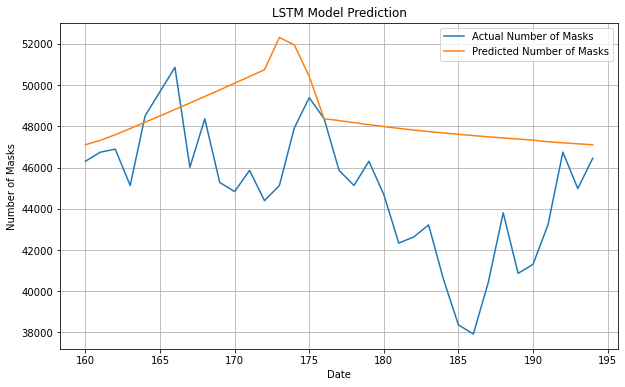

In [39]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index[time_steps:], y_test_actual, label='Actual Number of Masks')
plt.plot(y_test.index[time_steps:], y_pred, label='Predicted Number of Masks')
plt.title('LSTM Model Prediction')
plt.xlabel('Date')
plt.ylabel('Number of Masks')
plt.legend()
plt.grid(True)
plt.show()
